In [1]:
"""
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive
!pwd
"""

Mounted at /content/gdrive
/content/gdrive/MyDrive
/content/gdrive/MyDrive


In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import tests
#from tests import test_prediction, test_generation

In [3]:
#%cd hw4p1/dataset

/content/gdrive/MyDrive/hw4p1/dataset


In [84]:
# load all that we need

dataset = np.load('wiki.train.npy', allow_pickle=True)
devset = np.load('wiki.valid.npy', allow_pickle=True)
fixtures_pred = np.load('prediction.npz')  # dev
fixtures_gen = np.load('generation.npy')  # dev
fixtures_pred_test = np.load('prediction_test.npz')  # test
fixtures_gen_test = np.load('generation_test.npy')  # test
vocab = np.load('vocab.npy')

In [85]:
# data loader

class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle


    def __iter__(self):
        
        if self.shuffle:
            np.random.shuffle(self.dataset)
        # concatenate your articles and build into batches
        concats = np.concatenate(self.dataset)

        p = np.random.random_sample()
            
        if p < 0.95:
            seqlens = int(np.random.normal(70,5))
        else:
            seqlens = int(np.random.normal(35,5))
 
        
        concat_len = (len(concats)// seqlens) * seqlens
        
        x = torch.from_numpy(concats[:concat_len])
        y = torch.from_numpy(concats[1: concat_len+1])

        x_set = []
        y_set = []
        
        idx = 0
        while idx < concat_len:
          x_set.append(x[idx: idx+seqlens])
          y_set.append(y[idx: idx+seqlens])
          idx += seqlens

       
        num_batch =len(x_set)//self.batch_size
   
        x_set = torch.stack(x_set)[:num_batch * self.batch_size]
        y_set = torch.stack(y_set)[:num_batch * self.batch_size]

        x_set = x_set.view(num_batch,self.batch_size, -1).long()
        y_set = y_set.view(num_batch,self.batch_size, -1).long()

        for l in range(len(x_set)):
          current_x = x_set[l]
          current_y = y_set[l]          
          yield current_x, current_y
        
      

In [86]:
class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

In [143]:
class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size, hidden = 1150, embed = 400):#embed = hidden
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed)
        self.dropout = LockedDropout()
        
        self.lstm1 = nn.LSTM(input_size = embed, hidden_size = hidden, 
                            num_layers=1, batch_first=True)
                     
        self.lstm2 = nn.LSTM(input_size = embed, hidden_size = hidden, 
                            num_layers=1, batch_first=True)
        
        self.lstm3 = nn.LSTM(input_size = embed, hidden_size = hidden, 
                            num_layers=1, batch_first=True)
    
        self.output = nn.Linear(hidden, vocab_size)
        self.hidsize = hidden
        self.vocab_size = vocab_size
        
        #weight tying
        self.output.weight = self.embedding.weight
   

    def forward(self, x, h0 = None):
        
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        if  'array' in str(type(x)):
          x = torch.tensor(x)
  
        x = x.to(device)
        x = self.embedding(x)
        x = self.dropout(x, 0.3)
        raw_output = []

        hnew = []  
        outputs = []
        x,h0 = self.lstm1(x,h0)
        x = self.dropout(x,0.4)
        x,h0 = self.lstm2(x,h0)
        x = self.dropout(x, 0.4)
        x, h0 = self.lstm3(x,h0)
      
        output = self.output(self.dropout(x))
        
        #print(output.shape)

        return output.permute(0,2,1), raw_output
        



In [144]:
# model trainer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr = 0.003,
                                         weight_decay = 1.2e-6)
        self.scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', 0.5,1)

        self.criterion = torch.nn.CrossEntropyLoss()

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
           
            epoch_loss += self.train_batch(inputs, targets)
            

        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs

        
        """
        self.optimizer.zero_grad()
        
        
        targets = targets.to(device)
        inputs = inputs.to(device)

        outputs, raw_output = self.model(inputs)

        loss = self.criterion(outputs, targets) 
        loss.backward()
        self.optimizer.step()
    
        return loss

    
    def test(self):
        # don't change these

        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])  #changed
        generated = test_generation(fixtures_gen, generated_logits, vocab) #changed
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab) #changed
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
        self.scheduler.step(nll)
        for param_group in self.optimizer.param_groups:
          print(param_group['lr'])
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [145]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        model.eval()
        with torch.no_grad():
            output,_ = model(inp)
            output = output.permute(0,2,1)
            
        return output[:,-1].cpu().detach().numpy()

        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        
        """
        model.eval()
        with torch.no_grad():
            gen = []
            inp = torch.tensor(inp).to(device)
            output,_ = model(inp)
            output = output.permute(0,2,1)

          
            o = output[:,-1]
            
            w = torch.argmax(o, dim = 1).unsqueeze(1)
            word_cat = torch.cat((inp, w), dim = 1)
            gen.append(w)
  
            for f in range(forward -1):
              out,_ = model(word_cat)
              out = out.permute(0,2,1)
              o = out[:,-1]
              w = torch.argmax(o, dim = 1).unsqueeze(1)
              word_cat = torch.cat((word_cat, w), dim = 1)
             
        return  word_cat[:,-forward:].cpu().numpy()

In [146]:

# TODO: define other hyperparameters here

NUM_EPOCHS = 20
BATCH_SIZE = 128


In [147]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1620608345


In [148]:
import numpy as np
"""this is from the test.py
def log_softmax(x, axis):
    ret = x - np.max(x, axis=axis, keepdims=True)
    lsm = np.log(np.sum(np.exp(ret), axis=axis, keepdims=True))
    return ret - lsm


def array_to_str(arr, vocab):
    return " ".join(vocab[a] for a in arr)


def test_prediction(out, targ):
    out = log_softmax(out, 1)
    nlls = out[np.arange(out.shape[0]), targ]
    nll = -np.mean(nlls)
    return nll

def test_generation(inp, pred, vocab):
    outputs = u""
    for i in range(inp.shape[0]):
        w1 = array_to_str(inp[i], vocab)
        w2 = array_to_str(pred[i], vocab)
        outputs += u"Input | Output #{}: {} | {}\n".format(i, w1, w2)
    return outputs
""" 

In [149]:

model = LanguageModel(len(vocab), hidden =400, embed = 400).to(device)
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)


In [151]:
best_nll = 4.5
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    #print(nll)
  
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()
    

[TRAIN]  Epoch [17/15]   Loss: 4.8968
0.003
[VAL]  Epoch [17/15]   Loss: 4.5460
[TRAIN]  Epoch [18/15]   Loss: 4.8659
0.003
[VAL]  Epoch [18/15]   Loss: 4.5731
[TRAIN]  Epoch [19/15]   Loss: 4.8205
0.0015
[VAL]  Epoch [19/15]   Loss: 4.6618
[TRAIN]  Epoch [20/15]   Loss: 4.7124
0.0015
[VAL]  Epoch [20/15]   Loss: 4.4907
Saving model, predictions and generated output for epoch 3 with NLL: 4.490713
[TRAIN]  Epoch [21/15]   Loss: 4.6622
0.0015
[VAL]  Epoch [21/15]   Loss: 4.5088
[TRAIN]  Epoch [22/15]   Loss: 4.6388
0.00075
[VAL]  Epoch [22/15]   Loss: 4.5728
[TRAIN]  Epoch [23/15]   Loss: 4.5698
0.00075
[VAL]  Epoch [23/15]   Loss: 4.5685
[TRAIN]  Epoch [24/15]   Loss: 4.5503
0.000375
[VAL]  Epoch [24/15]   Loss: 4.5970
[TRAIN]  Epoch [25/15]   Loss: 4.5112
0.000375
[VAL]  Epoch [25/15]   Loss: 4.6429
[TRAIN]  Epoch [26/15]   Loss: 4.4998
0.0001875
[VAL]  Epoch [26/15]   Loss: 4.6050
[TRAIN]  Epoch [27/15]   Loss: 4.4799
0.0001875
[VAL]  Epoch [27/15]   Loss: 4.6474
[TRAIN]  Epoch [28/15

KeyboardInterrupt: ignored

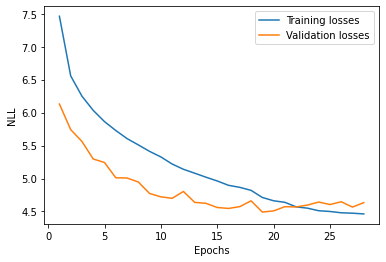

In [152]:

# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [50]:
print (trainer.generated[-1]) 

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | not to . The two @-@ month line of .
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = <eol> On July May , the first
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | @-@ selling single , " The Year " , was
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | <unk> , <unk> , <unk> , <unk> ) , <unk>
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | @-@ day @-@ field <unk> , and a few days
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | was also reported to have been used for the game
Input | Output #6: <unk> , $ 96 million USD ) . Damage 